# Нейронные сети

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [2]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [4]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
                
        self.in_features = in_features
        self.out_features = out_features
        
        np.random.seed(42)
        self.w = (np.random.sample((in_features, out_features)) * 2 - 1) / 10 # матрица размера [in_features, out_features]
        self.b = (np.random.sample(out_features) * 2 - 1) / 10 # вектор размера [out_features]
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        
        self.input = copy.deepcopy(x)
        
        return x @ self.w + self.b
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """

        grad_x = d @ self.w.T
        self.grad_w = self.input.T @ d
        self.grad_b = np.sum(d, axis=0)
        
        return grad_x
        
    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """

        self.w -= alpha * self.grad_w
        self.b -= alpha * self.grad_b
        

In [5]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        
        self.input = copy.deepcopy(x)

        return np.maximum(0, self.input)
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        
        return d * (self.input > 0)
        
        
class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    def __init__(self):
        pass
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        
        result = np.exp(copy.deepcopy(x))

        return result / result.sum(axis=1)[:, np.newaxis]
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        
        pass # в слой перед softmax-ом сразу передадим градиент композиции cross entropy и softmax

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [37]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        
        self.modules = modules
        self.modules.append(Softmax())
        
        self.epochs = epochs
        self.alpha = alpha
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        
        for _ in range(self.epochs):
            for pos in range(0, X.shape[0], batch_size):
                current_batch_size = min(batch_size, X.shape[0] - pos)
                
                result = copy.deepcopy(X[pos : pos + current_batch_size])
                batch_y  = copy.deepcopy(y[pos : pos + current_batch_size])
                
                for modul in self.modules:
                    result = modul.forward(result)
                
                self.n_classes = result.shape[1]
                
                result[np.arange(result.shape[0]), batch_y] -= 1 # теперь в result лежит градиент композиции сross entropy и softmax-a
                    
                for modul in (self.modules[:-1])[::-1]: # без softmax слоя
                    result = modul.backward(result)
                    modul.update(self.alpha)
                                
        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        
        probas = copy.deepcopy(X)
        for modul in self.modules:
            probas = modul.forward(probas)
        
        return probas
        
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [38]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [39]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p1 = MLPClassifier([
        Linear(X.shape[1], 64),
        ReLU(),
        Linear(64, 64),
        ReLU(),
        Linear(64, len(np.unique(y)))
    ], alpha=0.05)

    p1.fit(X, y)
    best_acc = max(np.mean(p1.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 1.0


In [40]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(X.shape[1], 64),
        ReLU(),
        Linear(64, 64),
        ReLU(),
        Linear(64, len(np.unique(y)))
    ])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.935


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [74]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)

        self.fc1 = nn.Linear(12 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    
    y_pred = model.forward(X)

    loss = nn.CrossEntropyLoss()

    return loss(y_pred, y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [75]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [76]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.1455782096099854 | Test loss 2.0148253257751465
Epoch 1 | Train loss 1.9566606087493896 | Test loss 1.8883194715499878
Epoch 2 | Train loss 1.8456227488327026 | Test loss 1.7758480083465575
Epoch 3 | Train loss 1.7311101616287232 | Test loss 1.6969477132797242
Epoch 4 | Train loss 1.6476817267990111 | Test loss 1.6079809949874877
Epoch 5 | Train loss 1.5956421734619142 | Test loss 1.5609734718322754
Epoch 6 | Train loss 1.5617684621810912 | Test loss 1.5548090370178222
Epoch 7 | Train loss 1.5505534083175658 | Test loss 1.5147695301055908
Epoch 8 | Train loss 1.5014754904937744 | Test loss 1.4934063514709472
Epoch 9 | Train loss 1.4890406032562256 | Test loss 1.4699121244430542
Epoch 10 | Train loss 1.4687965659332276 | Test loss 1.45623053855896
Epoch 11 | Train loss 1.4453508493423461 | Test loss 1.4393410747528077
Epoch 12 | Train loss 1.4440991391372682 | Test loss 1.425937425994873
Epoch 13 | Train loss 1.4160287814331054 | Test loss 1.407286007499695
Epoch 

Построим график функции потерь

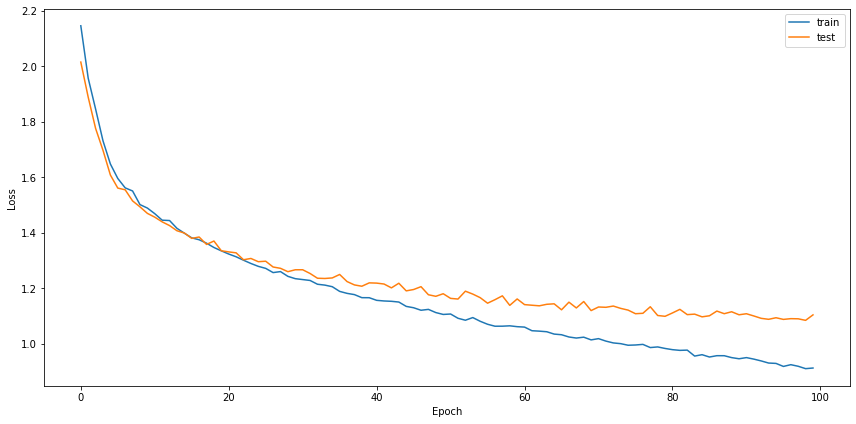

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [78]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6146
Precision [0.70259067 0.72708758 0.52397661 0.42250287 0.51011434 0.6489726
 0.57416608 0.68495935 0.7394297  0.62207358]
Recall [0.678 0.714 0.448 0.368 0.58  0.379 0.809 0.674 0.752 0.744]
Mean Precision 0.6155873365714036
Mean Recall 0.6146
